In [1]:
from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances


# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from numpy import arange, ones
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
from matplotlib import colors 
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure

from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os
import warnings
warnings.filterwarnings("ignore")

# from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor

import dask
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)
import cartopy.feature as cfeature

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import dask
# import cmocean.cm as cmo #also for pretty color palettes
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
import sys
import csv
# to access intake catalog of eerie
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")


###Lexieland
import os,sys
from config import *

sys.path.append('./RCLVatlas')
from subfunctions_for_RCLV_atlas import read_RCLV_CSV_untracked,read_RCLV_CSV_tracked,save_RCLV_CSV
from mainfunctions_for_RCLV_atlas import *

from scipy.spatial import ConvexHull

from fun_baby import eulerian_eddy


## 1. get data

1.1 trajectory data

In [2]:
# traj_path_8='/work/bk1377/b382618/RCLVs/8day/lang_traj/20101227_8days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr'
traj_path_8='/work/bk1377/b382618/RCLVs/32day/lang_traj/20100525_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr'

ds_8 = xr.open_zarr(traj_path_8)
lons = ds_8['lon']  
lats = ds_8['lat']  
times = ds_8['time']

1.2 lagrangian data

All tracked 8 day eddies as a csv. Mby need to change to a pandas df

In [3]:
# RCLV_path = "/work/bk1377/b382618/RCLVs/8day/RCLV_dir_2/changedRCLV_20100501_20101227_atlas.csv"
RCLV_path = '/work/bk1377/b382618/RCLVs/32day/RCLV_dir/changedRCLV_20100525_20101203_untracked.csv'

# open as csv file which is a list of lists

RCLV_data = []
with open(RCLV_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        if i == 0:
            RCLV_data.append(row)
        else:
            #reformat so that everything except for the date and orientation is a float
            RCLV_data.append([row[0],float(row[1]),row[2]] + [float(i) for i in row[3:]])
        i += 1

RCLV_data = np.array(RCLV_data,dtype=object) # Convert the list to a NumPy array


1.3 eulerian data

In [4]:
c = TrackEddiesObservations.load_file((
        "/home/b/b382618/eul_eddies/Cyclonic.nc")
)
a = TrackEddiesObservations.load_file((
        "/home/b/b382618/eul_eddies/Anticyclonic.nc")
)

In [5]:
### select for time

a_langtime=a.extract_with_period((22266, 22275))
c_langtime=c.extract_with_period((22266, 22275))

In [6]:
### delect for area

x0, x1, y0, y1 = 180, 210, 10, 40
area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
a_sub = a_langtime.extract_with_area(area, full_path=True)
c_sub = c_langtime.extract_with_area(area, full_path=True)

## 2. prep to run particles

In [7]:
### some initial grid needed for something
traj_lat=ds_8.lat[:,0].values
traj_lon=ds_8.lon[:,0].values
traj_lat_unique = np.unique(traj_lat)
traj_lon_unique = np.unique(traj_lon)

#### lagrangian

In [8]:
date_good=20101227
RCLV_data = np.array(RCLV_data,dtype=object)
RCLV_data_this_day = RCLV_data[np.where([r[0]==str(date_good) for r in RCLV_data])[0]]
RCLV_bnds = [r[9:] for r in RCLV_data_this_day] # boundary coordinates

In [10]:
onep=RCLV_bnds[0]
vertices = [[onep[i], onep[i + 1]] for i in range(0, len(onep), 2)]
# vertices

IndexError: list index out of range

In [ ]:
x_points_inside, y_points_inside = find_polygon_pts(vertices,traj_lon_unique,traj_lat_unique)


#### eulerian

In [77]:
eddy = c_sub.extract_ids([237938])
e=eddy.extract_with_period((22274, 22275))
lat_points = e.effective_contour_latitude
lon_points = e.effective_contour_longitude

In [80]:
lat_points = lat_points.flatten()
lon_points = lon_points.flatten()

# Set the number of decimal places
decimal_places = 10

# Create vertices by zipping individual elements, rounded to the specified decimal places
vertices_e = [(round(float(lon), decimal_places), round(float(lat), decimal_places)) for lon, lat in zip(lon_points, lat_points)]
# vertices_e

In [81]:
x_points_inside_e, y_points_inside_e = find_polygon_pts(vertices_e,traj_lon_unique,traj_lat_unique)


#### plot them

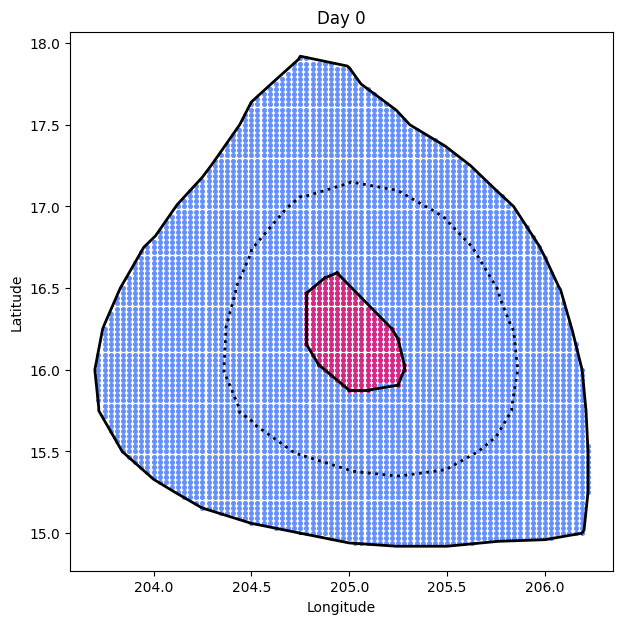

In [33]:
day=0
# eddy_day0_lons,eddy_day0_lats,_ = extract_particles_after_time(ds_8,x_points_inside,y_points_inside,traj_lon_unique,sim_params,day) #day 0 data
# eddy_day0_lons_e,eddy_day0_lats_e,_ = extract_particles_after_time(ds_8,x_points_inside_e,y_points_inside_e,traj_lon_unique,sim_params,day) #day 0 data


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# plt.figure(figsize=(10, 6))
eul=plt.scatter(eddy_day0_lons_e, eddy_day0_lats_e, color="#648FFF", marker='o', s = 7)
rclv=plt.scatter(eddy_day0_lons, eddy_day0_lats, color="#DC267F", marker='o', s = 7)
points = np.column_stack((eddy_day0_lons, eddy_day0_lats))
hull = ConvexHull(points)



# Plot convex hull edges
for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], 'black', lw=2)

# Add labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Day " +str(day))
# plt.xlim([195.75, 198])  # Set longitude limits
# plt.ylim([18.9, 20.5]) 
e.display(ax=ax, extern_only=True, linestyle="-", color='black', lw=2)
e.display(ax=ax, intern_only=True, linestyle="dotted", color='black', lw=2)
# plt.grid(True)
# plt.savefig('/home/b/b382618/eddy_figs/trajectories/one_eddy/try1_'+str(day)+ 'day.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [88]:
traj_1

<xarray.Dataset> Size: 48MB
Dimensions:     (trajectory: 921600)
Coordinates:
    obs         int32 4B 31
  * trajectory  (trajectory) int64 7MB 0 1 2 3 4 ... 921596 921597 921598 921599
Data variables:
    lat         (trajectory) float32 4MB dask.array<chunksize=(921600,), meta=np.ndarray>
    lon         (trajectory) float32 4MB dask.array<chunksize=(921600,), meta=np.ndarray>
    time        (trajectory) datetime64[ns] 7MB dask.array<chunksize=(921600,), meta=np.ndarray>
    u           (trajectory) float64 7MB dask.array<chunksize=(921600,), meta=np.ndarray>
    v           (trajectory) float64 7MB dask.array<chunksize=(921600,), meta=np.ndarray>
    vort        (trajectory) float64 7MB dask.array<chunksize=(921600,), meta=np.ndarray>
    z           (trajectory) float32 4MB dask.array<chunksize=(921600,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SpinnyParticleAdvectionRK4CalcVort
    parcels_mesh:           spherical
    parcels_version:        3.0.4

In [89]:
traj_1 = ds_8.isel(obs=0)

In [92]:
eddy = c_sub.extract_ids([237938])
e=eddy.extract_with_period((22274, 22275))
# lat_points = e.effective_contour_latitude
# lon_points = e.effective_contour_longitude

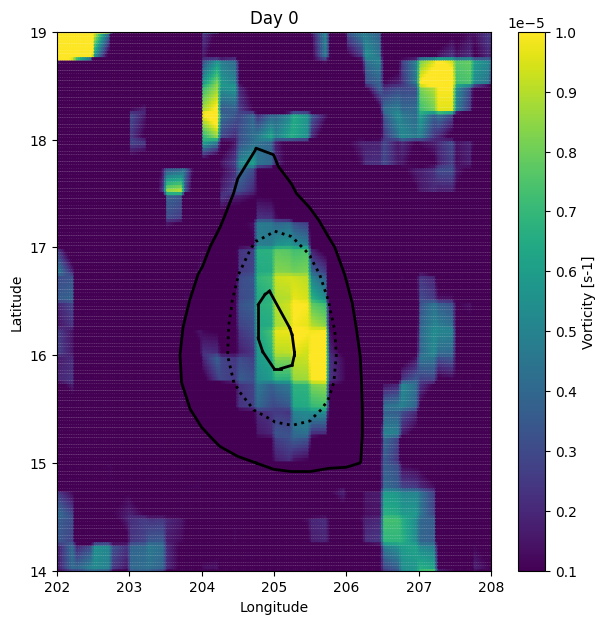

In [108]:
day=0
# eddy_day0_lons,eddy_day0_lats, eddy_day0_vort = extract_particles_after_time(ds_8,x_points_inside,y_points_inside,traj_lon_unique,sim_params,day) #day 0 data
# eddy_day0_lons_e,eddy_day0_lats_e, eddy_day0_vort_e = extract_particles_after_time(ds_8,x_points_inside_e,y_points_inside_e,traj_lon_unique,sim_params,day) #day 0 data


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# plt.figure(figsize=(10, 6))

traj_lon = traj_1.lon
traj_lat = traj_1.lat
traj_vort = traj_1.vort



# Define a shared colormap and normalization
vmin, vmax = 1e-6, 1e-5  # Set the range of color values
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.viridis



back=plt.scatter(traj_lon, traj_lat, c=traj_vort, marker='o', s = 3, norm=norm)


eul=plt.scatter(eddy_day0_lons_e, eddy_day0_lats_e, c=eddy_day0_vort_e, marker='o', s = 3, norm=norm)
rclv=plt.scatter(eddy_day0_lons, eddy_day0_lats, c=eddy_day0_vort, marker='o', s = 3, norm=norm)
points = np.column_stack((eddy_day0_lons, eddy_day0_lats))
hull = ConvexHull(points)


# Plot convex hull edges
for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], 'black', lw=2)


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Vorticity [s-1]')

# Add labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Day " +str(day))
plt.xlim([202, 208])  
plt.ylim([14, 19]) 
e.display(ax=ax, extern_only=True, linestyle="-", color='black', lw=2)
e.display(ax=ax, intern_only=True, linestyle="dotted", color='black', lw=2)
# plt.grid(True)
# plt.savefig('home/b/b382618/eddy_figs/trajectories/one_eddy/eul_lang_background_vorticity/a_'+str(day)+ 'day.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## animation of 8 day eddy color blind friendly colors

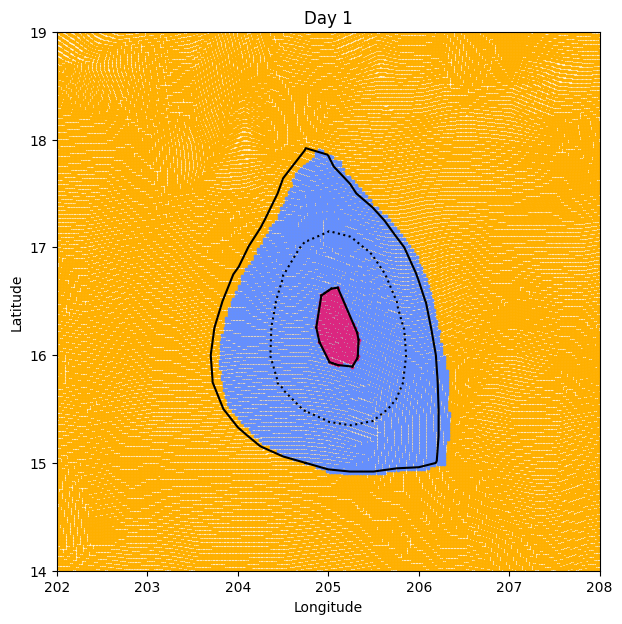

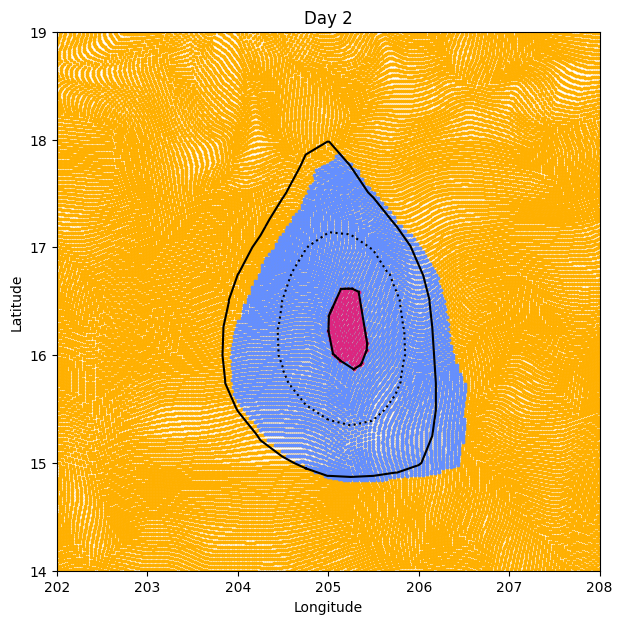

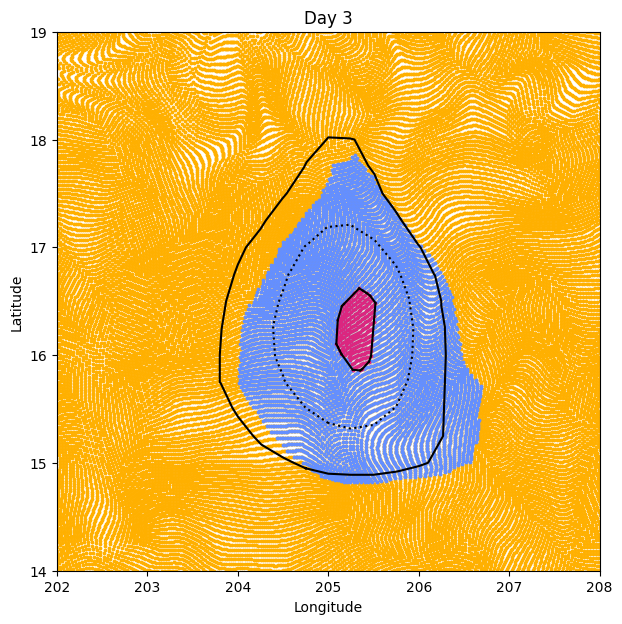

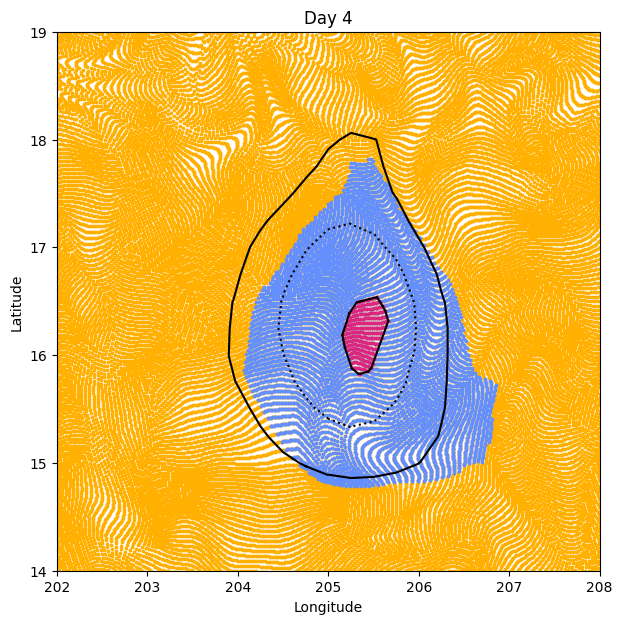

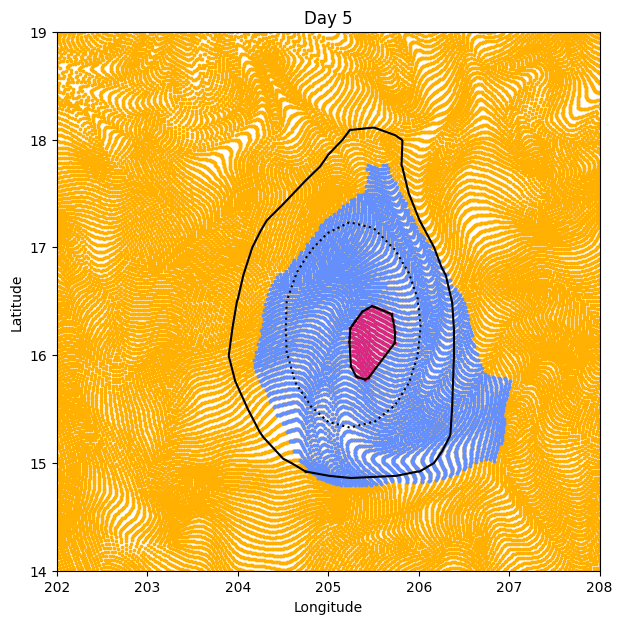

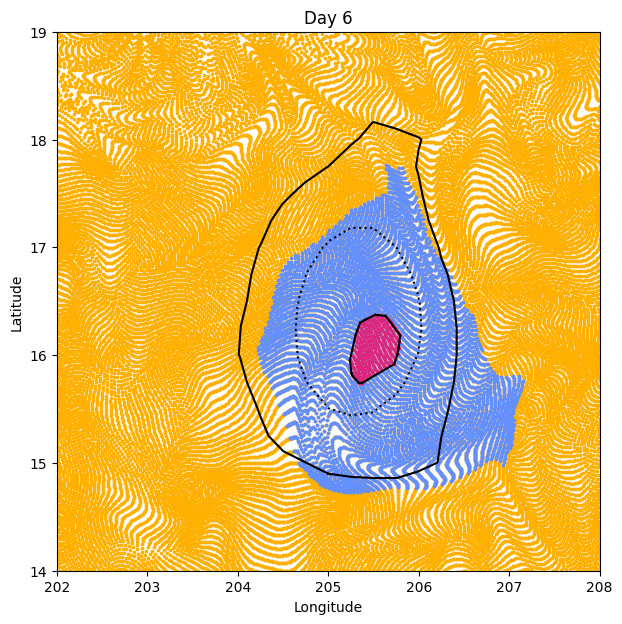

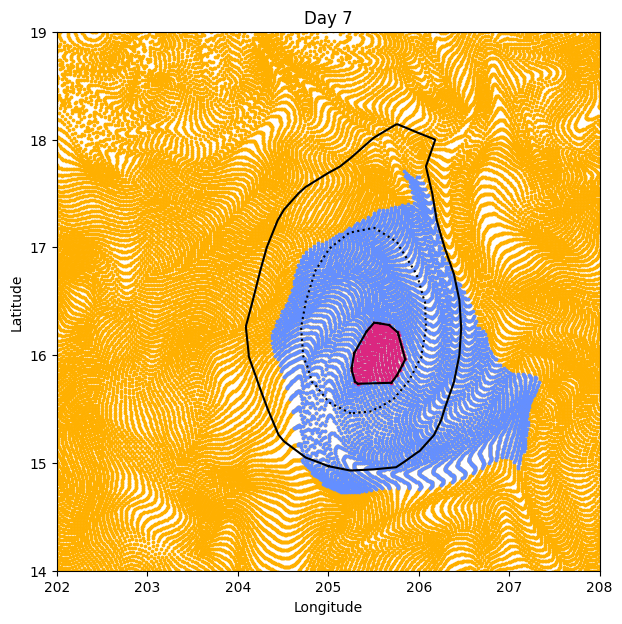

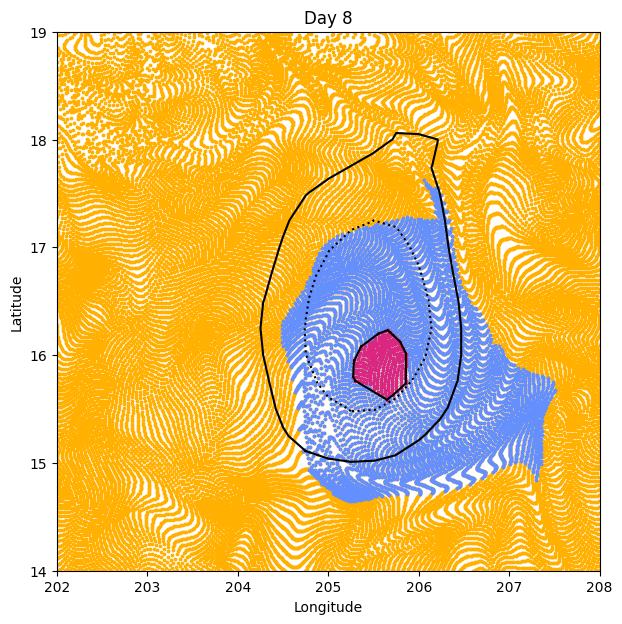

In [85]:
eul_day1 = 22274
eul_day2 = 22275


for i in range(1,9):
    day=i

    ########## for partilces
    eddy_day0_lons,eddy_day0_lats,_ = extract_particles_after_time(ds_8,x_points_inside,y_points_inside,traj_lon_unique,sim_params,day) #day 0 data
    eddy_day0_lons_e,eddy_day0_lats_e,_ = extract_particles_after_time(ds_8,x_points_inside_e,y_points_inside_e,traj_lon_unique,sim_params,day) #day 0 data
    ### background particles
    traj_1= ds_8.isel(obs=(i*4)-1) # you have to -1 because it is indexing. will not work for day=0
    traj_lon = traj_1.lon
    traj_lat = traj_1.lat

    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    back=plt.scatter(traj_lon, traj_lat, color="#FFB000", marker='o', s = 3)
    eul=plt.scatter(eddy_day0_lons_e, eddy_day0_lats_e, color="#648FFF", marker='o', s = 3)
    rclv=plt.scatter(eddy_day0_lons, eddy_day0_lats, color="#DC267F", marker='o', s = 3)
    points = np.column_stack((eddy_day0_lons, eddy_day0_lats))
    hull = ConvexHull(points)
    # Plot convex hull edges
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'black')


    ############ for eulerian outlines

    e=eddy.extract_with_period((eul_day1, eul_day2))
    e.display(ax=ax, extern_only=True, linestyle="-", color='black')
    e.display(ax=ax, intern_only=True, linestyle="dotted", color='black')
    eul_day1=eul_day1-1
    eul_day2=eul_day2-1
    
    # Add labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Day " +str(day))
    plt.xlim([202, 208])  
    plt.ylim([14, 19]) 
    plt.savefig('/home/b/b382618/eddy_figs/trajectories/one_eddy/trach/one_'+str(day)+ 'day.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


## 32-day eddies

## Animation

try:
1. https://nbviewer.org/github/OceanParcels/parcels_gallery/blob/main/scripts_ipynb/parcels_trails.ipynb
2. 